In [1]:
import glob
import pandas as pd
import datetime

import abstract_reader


abstractlist = glob.glob("abstracts/*")

xml_elements = ['datecreated', 'title', 'articletitle', 'abstracttext', 'language',  'country', 'publicationstatus']

In [2]:
df = abstract_reader.create_df(abstractlist, xml_elements)

In [3]:
df.shape

(2653, 7)

In [4]:
df[:5]

,datecreated,title,articletitle,abstracttext,language,country,publicationstatus
0,2001-03-06,diabetes care,pioglitazone hydrochloride monotherapy improve...,evaluate efficacy safety four doses pioglitazo...,eng,united states,ppublish
1,1996-05-28,archives of general psychiatry,sixmonth followup naltrexone psychotherapy alc...,goal study examine persistence naltrexones eff...,eng,united states,ppublish
2,2003-10-27,diabetes care,treattotarget trial randomized addition glargi...,compare abilities associated hypoglycemia risk...,eng,united states,ppublish
3,2001-05-04,clinical pediatrics,followup throat cultures necessary rapid antig...,frequency obtaining falsenegative group strept...,eng,united states,ppublish
4,2006-11-08,acta obstetricia et gynecologica scandinavica,prevention postpartum hemorrhage uterotonic ag...,determine efficacy intravenous oxytocin admini...,eng,denmark,ppublish


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Publications by counry

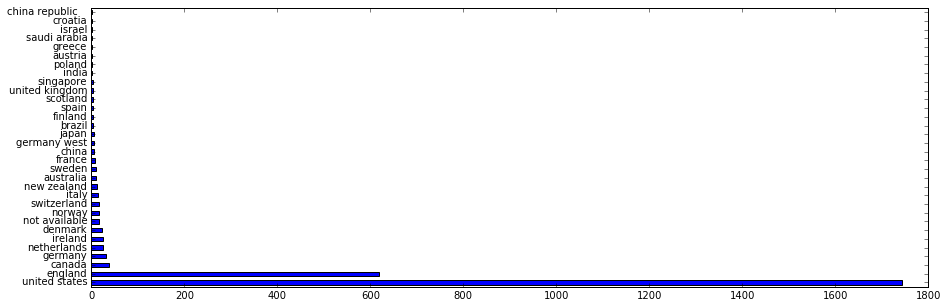

In [6]:
df['country'].value_counts().plot(kind='barh', figsize=(15, 5))

# Publication by language

In [7]:
df['language'].value_counts()

eng    2645
spa       3
dut       2
chi       1
fre       1
dan       1
Name: language, dtype: int64

# Publication by publication status

ppublish - published in print

epublish - electronically published only, never published in print

In [8]:
df['publicationstatus'].value_counts()

ppublish    2592
epublish      61
Name: publicationstatus, dtype: int64

# Publication by year of publication

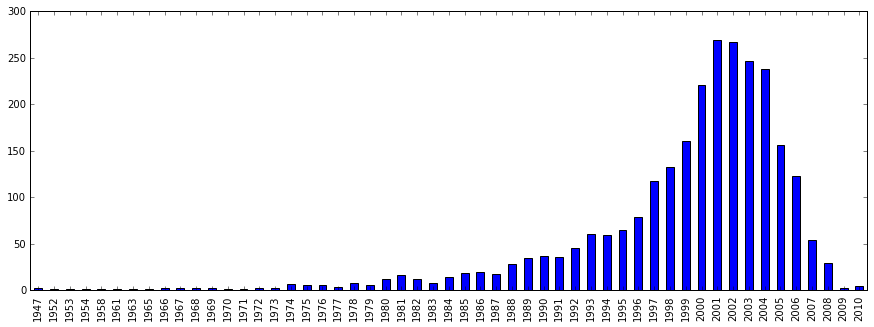

In [9]:
dates = pd.to_datetime(df.datecreated[df.datecreated != 'not available'])
dates.dt.year.value_counts(sort=False).sort_index().plot(kind='bar', figsize=(15, 5))

# epublish publication by year of publication

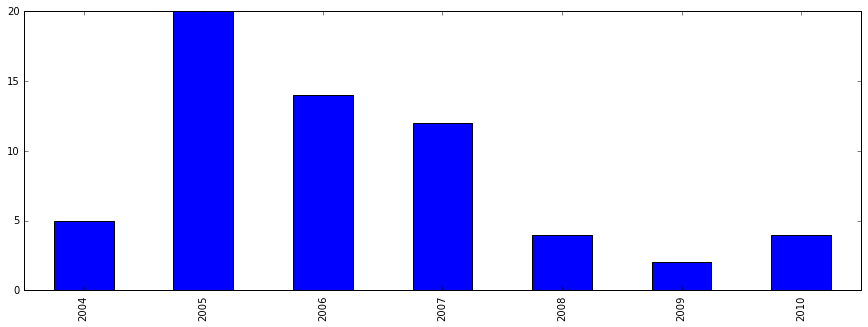

In [10]:
dates = pd.to_datetime((df.datecreated[(df.datecreated != 'not available') & (df.publicationstatus == 'epublish')]))
dates.dt.year.value_counts(sort=False).sort_index().plot(kind='bar', figsize=(15, 5))

# Publication by number of words

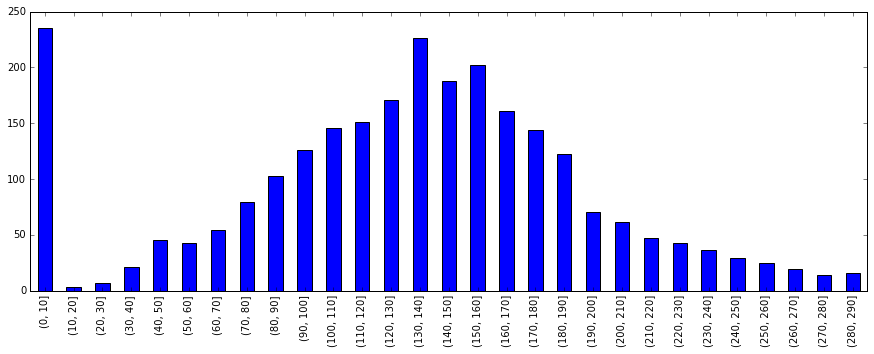

In [11]:
splitted_text = df.abstracttext.map(lambda x: len(x.split(' ')))
pd.value_counts(pd.cut(splitted_text, bins = range(0, 300, 10))).sort_index().plot(kind='bar', figsize=(15, 5))

# Top 20 used words in English publications

In [12]:
from collections import Counter
import operator

listtext_arrays = [i for i in df.abstracttext[df.language == 'eng'].tolist()]
listtext_arrays_split = [i.split(' ') for i in df.abstracttext[df.language == 'eng'].tolist()]
listtext_array = [item for sublist in listtext_arrays_split for item in sublist]

count_words = Counter(listtext_array)

In [13]:
count_words_sorted = sorted(count_words.iteritems(), key=operator.itemgetter(1), reverse=True)
for _ in range(20):
    print '{1:<7} {0}'.format(count_words_sorted[_][0], count_words_sorted[_][1])

5775    patients
3304    treatment
2448    group
2397    p
2079    study
2040    risk
1771    women
1713    trials
1619    studies
1515    placebo
1448    years
1436    ci
1379    therapy
1364    compared
1332    clinical
1216    data
1198    disease
1159    significant
1150    children
1054    two


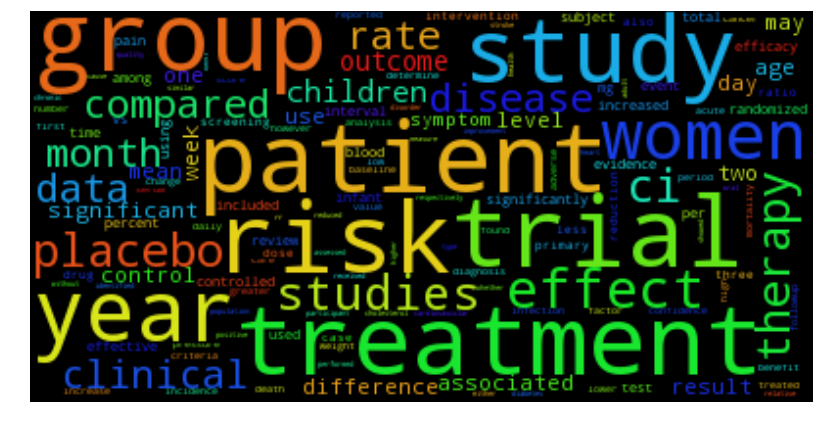

In [14]:
import wordcloud

plt.figure(figsize=(15,7))
plt.imshow(wordcloud.WordCloud(max_font_size=50).generate(' '.join(listtext_array)))
plt.axis("off")
plt.show()

# Report Part 1
More than 99% of articles are on English and most publications are from United States and England.

Almost 10% of articles don't have abstracttext field. 

Publications electronically published only are 2% of all publications from 2004 to 2010.

# Task 2

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Count TF-IDF
tfidf = TfidfVectorizer()
tfidf.fit_transform(listtext_arrays)
tfidf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

# Extract top 200 rank words
tfidf_dict_sorted = sorted(tfidf_dict.iteritems(), key=operator.itemgetter(1), reverse=True)
tfidf_top_200 = [_[0] for _ in tfidf_dict_sorted][:300]
tfidf_top_200[:20]

[u'institutionalised',
 u'individuallyadapted',
 u'significances',
 u'centimeter',
 u'towns',
 u'inclusively',
 u'igfigbp',
 u'whoops',
 u'lactoferrin',
 u'nonexercise',
 u'perennial',
 u'pierce',
 u'pigment',
 u'nonselegiline',
 u'reconstructions',
 u'endometrialablation',
 u'wordlists',
 u'nondepressive',
 u'multiorgan',
 u'clinicianrequested']

In [16]:
# remove top 7 by hands as typo/not interested - help model ^^
tfidf_top_200 = tfidf_top_200[8:]

In [17]:
import gensim

# Word2Vec model
model = gensim.models.Word2Vec(listtext_arrays_split, size=500, window=5, min_count=1)

#remove wrong words by model
for _ in range(200):
    bad_w = model.doesnt_match(tfidf_top_200)
    tfidf_top_200.pop(tfidf_top_200.index(bad_w))

In [18]:
for _ in range(50):
    similar = model.most_similar(tfidf_top_200[_], topn=5)
    print '{0:<22} {1:<22} {2:<22} {3:<22}'.format(tfidf_top_200[_], similar[0][0], similar[1][0], similar[2][0])

perennial              agent                  preference             pharmacotherapy       
pierce                 interspace             travelers              tasks                 
pigment                pathologies            tree                   tear                  
wordlists              ascorbic               recommend              helicobacter          
oneleghop              perform                lyc                    investigations        
clavicular             outer                  enlargement            reflects              
frankinsence           displayed              images                 traditional           
herb                   educational            part                   nurse                 
mucate                 dichloralphenazone     isometheptene          sclerotherapy         
txa                    vertigo                true                   receptors             
unanswered             sphincter              lifestyle              aseptic    

# Report Part 2

Main idea is to use TF-IDF to get most important words in corpus and using Word2Vec remove redundant words and get synonyms. 

Think result can be improved by using English version of Wikipedia like a corpus for removing and getting synonyms.